In [18]:
# imports and loadings
import os
import sys
sys.path.insert(0, '../functions/')
import mRNA_ratios as mr
import create_data_for_single_gene as cdg

import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# settings
genes = ['b3255', 'b2323', 'b1092', 'b1288', 'b0185', 'b3256', 'b0954', 'b1093', 'b1091', 'b2316']

# below are the default flags used if nothing is pre-set
# set flags by editing the "saved_flags.csv" in the ../data folder
flags_df = pd.read_csv('../data/saved_flags.csv', index_col = 0)
t_half_life_deg = 300
stable_flags = { # these do not change gene by gene
    # overall
    'only_create_ratios' : True,
    'only_check_KdRNAPCrp' : True, # if True, quit out of code after generating KdRNAPCrp, done to see if it is generating valid values through sanity check plots
    'save_results' : True, # saves resulting figures and cAct/cInh values of the previous run to the save_results_run folder
    'include_Amy_samples' : True, # append on Amy's stationary phase samples to analysis
    'remove_outliers' : True, # removes samples that do not correlate well with others, see ../data_cleaning/1_locate_outliers_to_drop.ipynb
    'case' : 'argR', # only used for remove_outliers right now
    'drop_basal_conds' : False,
    
    # KdRNAPCrp optimization
    'KdRNAPCrp_sanity' : True, # if True, return sanity plots from this optimization
    # GAMs
    'supress_output' : False,
    'use_greedy' : True, # use the greedy algo values (if False, uses the results of the GA)
    'run_on_all' : False, # run on all genes that are in the saved output folder
    'limit_samples' : ['b2818', 'b3959', 'b3958', 'b3359', 'b3957', 'b0273', 'b3172', 'b3960', 'b4254'], #['b1101', 'b1817', 'b1818', 'b1819'], # if run_on_all is False, limit to these samples (or which of them are available)
    'delete_old' : True,
    'run_seperate' : False, # run cActivator and cInhibitor solvers seperately
    
    # input constants for GAMs (all get logged inside GAMs so pass in un-logged)
    'act_TF_conc_lo' : 1e-10,
    'act_TF_conc_up' : 1e-5,
    'act_Kd_lo' : 1e-10,
    'act_Kd_up' : 1e-6,
    'inh_TF_conc_lo' : 1e-10,
    'inh_TF_conc_up' : 1e-5,
    'inh_Kd_lo' : 1e-10,
    'inh_Kd_up' : 1e-6,
    # objective function weightings
    'weight_act_obj1' : 1,
    'weight_inh_obj1' : 1,
    'weight_act_obj2' : 0,
    'weight_inh_obj2' : 0,
    'weight_mRNA_match' : .1,
    'weight_act_corr' : 0.00000000000000001,
    'weight_inh_corr' : 0.00000000000000001,
    
    
    # misc
    'eq_str' : 'Eq(mRNARatio,((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
            KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
            cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
            KeqOpening)*RNAP))',
    
    # cell_constants'
    'cell_constants_RNAP': 10**-6,
    'cell_constants_mRNA_total': 1800, # Total mRNA/cell from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3554401
    'cell_constants_cell_volume': 10**-15, # Liters from https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100004&ver=19
    'cell_constants_kDeg': np.log(2)/t_half_life_deg, # Rate of degradation
    'cell_constants_promoterConcVal': 10**-9, # Promoter concentration
    'cell_constants_u': 1/3600, # Growth rate
}


def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"

    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)


In [27]:
# multiprocess run
gene = genes[0]

# overall setup
folders = [val for val in os.listdir('../data/saved_run_results') if 'run' in val]
if len(folders) == 0:
    run_ct = 1
else:
    run_ct = max([int(val.split('_')[1]) for val in folders]) + 1
new_run_folder = '../data/saved_run_results/run_'+str(run_ct)
os.mkdir(new_run_folder)

# put the flags df in there
flags_df.to_csv(new_run_folder+'/saved_flags.csv')

# setup inputs
temp_flags = dict(flags_df.loc[gene])

# need to convert some flags from strings to lists
for col in ['basal_conditions', 'target_range', 'cActivator', 'cInhibitor']:
    temp_flags[col] = ast.literal_eval(temp_flags[col])

# convert cell constants into a dictionary
temp_flags.update({'cell_constants' : {
    'RNAP' : stable_flags['cell_constants_RNAP'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
    'cell_volume' : stable_flags['cell_constants_cell_volume'],
    'kDeg' : stable_flags['cell_constants_kDeg'],
    'promoterConcVal' : stable_flags['cell_constants_promoterConcVal'],
    'u' : stable_flags['cell_constants_u'],
    'mRNA_total' : stable_flags['cell_constants_mRNA_total'],
}})
temp_flags.update({'eq_str' : stable_flags['eq_str']})
temp_flags.update({'save_results' : stable_flags['save_results']})
temp_flags.update({'save_results_folder' : new_run_folder})
temp_flags.update({'include_Amy_samples' : stable_flags['include_Amy_samples']})
temp_flags.update({'only_check_KdRNAPCrp' : stable_flags['only_check_KdRNAPCrp']})
temp_flags.update({'only_create_ratios' : stable_flags['only_create_ratios']})
temp_flags.update({'KdRNAPCrp_sanity' : stable_flags['KdRNAPCrp_sanity']})
temp_flags.update({'remove_outliers' : stable_flags['remove_outliers']})
temp_flags.update({'case' : stable_flags['case']})
temp_flags.update({'central_gene' : gene})
temp_flags.update({'drop_basal_conds' : stable_flags['drop_basal_conds']})

ret_figs = cdg.create_data_for_gene(temp_flags)
ratios_df = pd.read_pickle(new_run_folder+'/'+gene+'/ratios_df.pkl')

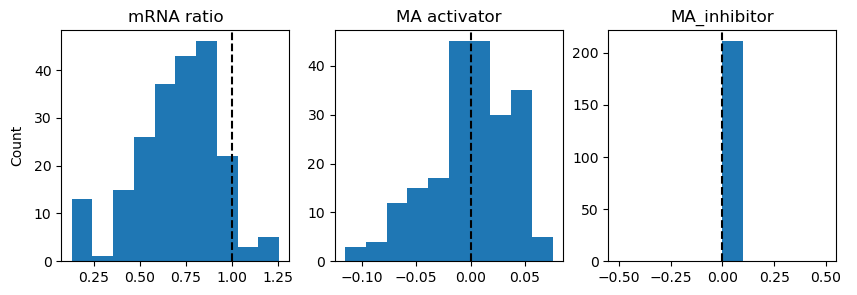

In [28]:
show_figure(ret_figs[0])

In [7]:
ratios_df = pd.read_pickle(new_run_folder+'/'+gene+'/ratios_df.pkl')

In [35]:
# loading merged log_tpm_file
# merge together log_tpm_df files
log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
starve_log_tpm = pd.read_csv('../data/validation_data_sets/stationary_phase/cleaned_log_tpm_qc.csv', index_col = 0)
to_blank_inds = list(set(log_tpm_df.index) - set(starve_log_tpm.index))
# need to create zero rows for missing values
zeros_data = {col : 0 for col in starve_log_tpm.columns}
zeros_df = pd.DataFrame(zeros_data, index = to_blank_inds)
starve_log_tpm = pd.concat([starve_log_tpm, zeros_df])
starve_log_tpm = starve_log_tpm.loc[log_tpm_df.index]
log_tpm_df = pd.concat([starve_log_tpm, log_tpm_df], axis = 1)

In [37]:
log_tpm_df.loc[genes]

,starve_series__t00_growth1,starve_series__t01_starve,starve_series__t02_starve,starve_series__t03_starve,starve_series__t04_starve,starve_series__t05_starve,starve_series__t06_starve,starve_series__t07_starve,starve_series__t08_starve,starve_series__t09_starve,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
b3255,9.283632,7.388023,6.880033,6.425577,6.177616,5.727570,5.629630,5.821482,5.932218,5.661304,...,7.059071,7.177445,9.432403,9.495849,9.284161,9.241968,9.533013,9.512488,10.056027,9.717390
b2323,9.966476,7.828430,6.648924,6.949779,6.857005,6.484764,6.593051,6.424606,6.219714,6.456289,...,8.677031,8.754402,9.636644,9.527143,9.349007,9.576695,9.541565,9.383844,9.490237,9.486850
b1092,8.990677,8.780263,7.715570,8.459263,8.576122,8.637527,8.545200,8.246635,8.370257,8.277775,...,8.712294,8.812430,9.211259,9.195798,9.781014,9.778010,9.723583,9.647995,9.543108,9.475250
b1288,10.482618,8.938078,8.102197,8.837398,8.955724,8.550407,8.606719,8.396291,8.327118,8.014342,...,10.015528,9.990581,10.445995,10.609688,10.689290,10.599791,10.607278,10.700865,10.647756,10.674816
b0185,8.584722,7.362739,6.695774,7.231669,7.063558,7.017200,6.902370,6.773666,6.749002,6.656534,...,8.878165,8.964665,9.579201,9.567450,9.463540,9.452854,9.336261,9.324596,9.153418,9.376532
b3256,9.710417,7.577475,6.567839,5.766843,5.717420,5.612280,5.552501,5.567795,5.762344,5.876226,...,7.723547,7.541629,10.234126,10.301505,10.136565,10.043373,9.878050,9.907600,10.013510,10.043114
b0954,10.752004,8.509650,7.636271,8.495830,8.458031,8.714822,8.903533,9.079404,9.310418,9.320713,...,9.394068,9.299554,10.673996,10.673927,10.001130,10.010913,9.833495,9.854527,10.088268,10.316776
b1093,10.487229,10.756447,10.454883,11.215766,11.485384,11.869135,11.930975,11.753342,11.668033,11.581051,...,10.596946,10.638384,10.530947,10.432243,11.064010,11.158734,10.956015,11.081573,10.676525,10.812453
b1091,8.105196,7.143680,6.475309,7.455606,7.499926,7.527993,7.769079,7.585949,7.552146,7.480302,...,7.506186,7.658414,8.435083,8.361452,8.658694,8.965575,9.148652,9.049420,8.729681,8.750363
b2316,8.872020,7.737913,6.709458,6.629196,6.371249,6.045700,5.760518,5.680671,5.796120,5.639216,...,8.981865,8.998519,9.992953,9.980279,9.995874,10.009795,9.867132,10.025281,9.968124,9.926366


In [69]:
# scale and normalize it
df = 2**log_tpm_df.loc[genes].T
normalized_df=(df-df.mean())/df.std()
normalized_df = normalized_df
normalized_df['avg_exp'] = normalized_df.mean(axis = 1)
normalized_df.sort_values(by = 'avg_exp')

,b3255,b2323,b1092,b1288,b0185,b3256,b0954,b1093,b1091,b2316,avg_exp
starve_series__t02_starve,-1.723752,-1.341440,-2.603308,-2.246981,-2.509595,-1.935480,-1.202748,-0.705148,-2.660605,-2.675548,-1.960460
starve_series__t18_starve,-1.816468,-1.073874,-2.732179,-2.243175,-2.511146,-1.885094,0.635766,-0.866820,-2.197048,-2.584241,-1.727428
starve_series__t12_starve,-1.863160,-1.324268,-2.472933,-2.400856,-2.572942,-1.994182,-0.192046,0.680539,-2.008182,-2.890675,-1.703871
starve_series__t16_starve,-1.750474,-1.116925,-2.369431,-2.319339,-2.554403,-1.802729,0.410117,0.015195,-1.990905,-2.682999,-1.616189
starve_series__t17_starve,-1.795822,-0.983782,-2.276465,-2.300409,-2.427540,-1.822453,0.572023,-0.624424,-1.882877,-2.512100,-1.605385
starve_series__t14_starve,-1.767090,-1.174960,-2.158074,-2.413724,-2.518532,-1.867736,0.163858,0.354708,-1.668759,-2.747824,-1.579813
starve_series__t10_starve,-1.859934,-1.362945,-2.236103,-2.320227,-2.488256,-2.043807,-0.588858,1.983943,-1.960347,-2.876039,-1.575257
starve_series__t11_starve,-1.821410,-1.334383,-2.039415,-2.439476,-2.496355,-1.970683,-0.266272,1.352363,-1.864609,-2.824528,-1.570476
starve_series__t03_starve,-1.813189,-1.305986,-1.745761,-1.853468,-2.227254,-2.055298,-1.020084,1.511140,-1.862515,-2.697270,-1.506969
starve_series__t01_starve,-1.584054,-1.148023,-1.215220,-1.782231,-2.140709,-1.650478,-1.016167,0.036712,-2.177194,-2.258131,-1.493549


In [70]:
normalized_df

,b3255,b2323,b1092,b1288,b0185,b3256,b0954,b1093,b1091,b2316,avg_exp
starve_series__t00_growth1,-0.303426,0.030031,-0.797616,0.243831,-0.812662,0.266857,0.516994,-0.632793,-0.942075,-1.279759,-0.371062
starve_series__t01_starve,-1.584054,-1.148023,-1.215220,-1.782231,-2.140709,-1.650478,-1.016167,0.036712,-2.177194,-2.258131,-1.493549
starve_series__t02_starve,-1.723752,-1.341440,-2.603308,-2.246981,-2.509595,-1.935480,-1.202748,-0.705148,-2.660605,-2.675548,-1.960460
starve_series__t03_starve,-1.813189,-1.305986,-1.745761,-1.853468,-2.227254,-2.055298,-1.020084,1.511140,-1.862515,-2.697270,-1.506969
starve_series__t04_starve,-1.851333,-1.317717,-1.566133,-1.769225,-2.327346,-2.060734,-1.030607,2.622290,-1.812025,-2.759436,-1.387227
starve_series__t05_starve,-1.905841,-1.357885,-1.465750,-2.031260,-2.352957,-2.071697,-0.953380,4.608673,-1.779239,-2.823580,-1.213291
starve_series__t06_starve,-1.915613,-1.347248,-1.615090,-1.999105,-2.412961,-2.077583,-0.887191,4.981160,-1.469728,-2.869029,-1.161239
starve_series__t07_starve,-1.895826,-1.363458,-2.037513,-2.113104,-2.474776,-2.076101,-0.817205,3.952735,-1.709485,-2.880225,-1.341496
starve_series__t08_starve,-1.883148,-1.380786,-1.873139,-2.147090,-2.486005,-2.055801,-0.711305,3.502067,-1.750509,-2.863834,-1.364955
starve_series__t09_starve,-1.912525,-1.360552,-1.997424,-2.281961,-2.526436,-2.042584,-0.706180,3.069198,-1.834572,-2.885798,-1.447883


In [67]:
normalized_df.mean(axis = 1)

starve_series__t00_growth1    -0.371062
starve_series__t01_starve     -1.493549
starve_series__t02_starve     -1.960460
starve_series__t03_starve     -1.506969
starve_series__t04_starve     -1.387227
starve_series__t05_starve     -1.213291
starve_series__t06_starve     -1.161239
starve_series__t07_starve     -1.341496
starve_series__t08_starve     -1.364955
starve_series__t09_starve     -1.447883
starve_series__t10_starve     -1.575257
starve_series__t11_starve     -1.570476
starve_series__t12_starve     -1.703871
starve_series__t14_starve     -1.579813
starve_series__t16_starve     -1.616189
starve_series__t17_starve     -1.605385
starve_series__t18_starve     -1.727428
starve_series__t21_growth2     0.037101
starve_series__t22_growth2    -0.163516
starve_series__t23_growth2    -0.199284
starve_series__t25_growth2    -0.417483
starve_series__t26_growth2    -0.637500
starve_series__t27_growth2    -0.787061
starve_series__t28_growth2    -0.762267
control__wt_glc__1             0.257575
